#**TEXT ANALYSIS** --> Using Word2Vec Embedding



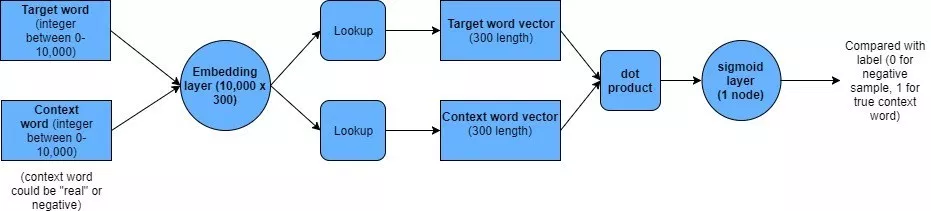

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, merge,concatenate,dot
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence

import urllib
import collections
import os
import zipfile

import numpy as np
import tensorflow as tf

In [0]:
def maybe_download(filename, url, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

In [0]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

In [0]:
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [0]:
def collect_data(vocabulary_size=10000):
    url = 'http://mattmahoney.net/dc/'
    filename = maybe_download('text8.zip', url, 31344016)
    vocabulary = read_data(filename)
    print(vocabulary[:7])
    data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                                vocabulary_size)
    del vocabulary  # Hint to reduce memory.
    return data, count, dictionary, reverse_dictionary

In [6]:
vocab_size = 10000
data, count, dictionary, reverse_dictionary = collect_data(vocabulary_size=vocab_size)
print(data[:7])

window_size = 3
vector_dim = 300
epochs = 200000

valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

Found and verified text8.zip
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse']
[5234, 3081, 12, 6, 195, 2, 3134]


In [7]:
sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(data, vocab_size, window_size=window_size, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples[:10], labels[:10])

[[3529, 6868], [2334, 1], [47, 30], [8366, 24], [1223, 4383], [5951, 4813], [2877, 609], [4651, 3292], [1213, 780], [7965, 8]] [0, 1, 1, 1, 0, 0, 0, 0, 0, 1]


In [8]:
input_target = Input((1,))
input_context = Input((1,))

In [9]:
embedding = Embedding(vocab_size, vector_dim, input_length=1, name='embedding')
target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

In [36]:
# setup a cosine similarity operation which will be output in a secondary model
similarity = dot([target, context], axes=1,normalize=True)

# now perform the dot product operation to get a similarity measure
# dot_product = merge([target, context], mode='dot', dot_axes=1)
similarity = Reshape((1,))(similarity)
# # add the sigmoid output layer
#output = Dense(1, activation='sigmoid')(similarity)
# # create the primary training model
model = Model(input=[input_target, input_context], output=similarity)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("re...)`
  if __name__ == '__main__':


In [37]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 300)       3000000     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 300, 1)       0           embedding[0][0]            

In [38]:
validation_model = Model(input=[input_target, input_context], output=similarity)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("re...)`
  """Entry point for launching an IPython kernel.


In [0]:
class SimilarityCallback:
    def run_sim(self):
        for i in range(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8  # number of nearest neighbors
            sim = self._get_sim(valid_examples[i])
            nearest = (-sim).argsort()[1:top_k + 1]
            log_str = 'Nearest to %s:' % valid_word
            for k in range(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log_str = '%s %s,' % (log_str, close_word)
            print(log_str)

    @staticmethod
    def _get_sim(valid_word_idx):
        sim = np.zeros((vocab_size,))
        in_arr1 = np.zeros((1,))
        in_arr2 = np.zeros((1,))
        in_arr1[0,] = valid_word_idx
        for i in range(vocab_size):
            in_arr2[0,] = i
            out = validation_model.predict_on_batch([in_arr1, in_arr2])
            sim[i] = out
        return sim
sim_cb = SimilarityCallback()

In [40]:
arr_1 = np.zeros((1,))
arr_2 = np.zeros((1,))
arr_3 = np.zeros((1,))
for cnt in range(epochs):
    idx = np.random.randint(0, len(labels)-1)
    arr_1[0,] = word_target[idx]
    arr_2[0,] = word_context[idx]
    arr_3[0,] = labels[idx]
    loss = model.train_on_batch([arr_1, arr_2], arr_3)
    if cnt % 100 == 0:
        print("Iteration {}, loss={}".format(cnt, loss))
    if cnt % 10000 == 0:
        sim_cb.run_sim()









Iteration 0, loss=16.11809539794922
Nearest to such: flexibility, milk, let, increased, yield, baptism, defend, tenth,
Nearest to five: genealogy, journalists, quite, inca, default, potter, notation, carrier,
Nearest to in: limitations, finland, rico, town, th, outdoor, owners, fail,
Nearest to been: archbishop, suppression, dinosaurs, indians, lover, functions, placed, eta,
Nearest to zero: pride, ward, chicago, ten, respected, least, symmetry, keen,
Nearest to use: programmers, players, narrow, versa, retained, asylum, feel, collector,
Nearest to the: deng, illegitimate, responses, arts, citizens, recently, iron, indies,
Nearest to years: viewer, myanmar, projects, raised, concludes, imperialism, pale, instant,
Nearest to all: regions, success, album, exploited, irc, weeks, default, silk,
Nearest to have: emission, friendship, genealogy, pounds, sized, austria, private, districts,
Nearest to may: terror, mikhail, writes, gnome, comics, rk, flora, uk,
Nearest to i: kiribati, n

KeyboardInterrupt: ignored

# **GLove vectors**

Traning dataset : 2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download

Due to performance constraints we have used 50d 100k most common words vocab

In [41]:
! pip install glove_python

     |████████████████████████████████| 266kB 3.4MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700326 sha256=43794a842119a630ea193b8deeb42b62e7aa4833da7955b54a819b0027b62375
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [0]:
import glove

In [43]:
import os, requests, shutil

glove_dir = './data/RNN/'
glove_100k_50d = 'glove.first-100k.6B.50d.txt'
glove_100k_50d_path = os.path.join(glove_dir, glove_100k_50d)

# These are temporary files if we need to download it from the original source (slow)
data_cache = './data/cache'
glove_full_tar = 'glove.6B.zip'
glove_full_50d = 'glove.6B.50d.txt'

#force_download_from_original=False
download_url= 'http://redcatlabs.com/downloads/deep-learning-workshop/notebooks/data/RNN/'+glove_100k_50d
original_url = 'http://nlp.stanford.edu/data/'+glove_full_tar

if not os.path.isfile( glove_100k_50d_path ):
    if not os.path.exists(glove_dir):
        os.makedirs(glove_dir)
    
    # First, try to download a pre-prepared file directly...
    response = requests.get(download_url, stream=True)
    if response.status_code == requests.codes.ok:
        print("Downloading 42Mb pre-prepared GloVE file from RedCatLabs")
        with open(glove_100k_50d_path, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
    else:
        # But, for some reason, RedCatLabs didn't give us the file directly
        if not os.path.exists(data_cache):
            os.makedirs(data_cache)
        
        if not os.path.isfile( os.path.join(data_cache, glove_full_50d) ):
            zipfilepath = os.path.join(data_cache, glove_full_tar)
            if not os.path.isfile( zipfilepath ):
                print("Downloading 860Mb GloVE file from Stanford")
                response = requests.get(download_url, stream=True)
                with open(zipfilepath, 'wb') as out_file:
                    shutil.copyfileobj(response.raw, out_file)
            if os.path.isfile(zipfilepath):
                print("Unpacking 50d GloVE file from zip")
                import zipfile
                zipfile.ZipFile(zipfilepath, 'r').extract(glove_full_50d, data_cache)

        with open(os.path.join(data_cache, glove_full_50d), 'rt') as in_file:
            with open(glove_100k_50d_path, 'wt') as out_file:
                print("Reducing 50d GloVE file to first 100k words")
                for i, l in enumerate(in_file.readlines()):
                    if i>=100000: break
                    out_file.write(l)
    
        # Get rid of tarfile source (the required text file itself will remain)
        #os.unlink(zipfilepath)
        #os.unlink(os.path.join(data_cache, glove_full_50d))

print("GloVE available locally")

GloVE available locally


In [44]:
word_embedding = glove.Glove.load_stanford( glove_100k_50d_path )
word_embedding.word_vectors.shape

(100000, 50)

In [45]:
word_embedding.most_similar('king')

[('prince', 0.8236179693335699),
 ('queen', 0.7839043010964116),
 ('ii', 0.7746230030635107),
 ('emperor', 0.7736247624872925)]

In [48]:
word_embedding.most_similar('bomb')

[('bombs', 0.9158880756189984),
 ('exploded', 0.8765999348562742),
 ('explosives', 0.8647324718485557),
 ('blast', 0.8647111908714112)]

In [0]:
def get_embedding_vec(word):
    idx = word_embedding.dictionary.get(word.lower(), -1)
    if idx<0:
        #print("Missing word : '%s'" % (word,))
        return np.zeros(  (EMBEDDING_DIM, ), dtype='float32')  # UNK
    return word_embedding.word_vectors[idx]

def get_similarity(word1,word2):
    vec1 = get_embedding_vec(word1)
    vec2 = get_embedding_vec(word2)
    return np.dot(vec1,vec2)/np.linalg.norm(vec1)/np.linalg.norm(vec2)


In [50]:
get_similarity('terror','bomb')

0.6301162216558565

In [51]:
get_similarity('pie','cake')

0.8639964477977128

In [52]:
get_similarity('terror','cake')

-0.0997189901030127